<a href="https://colab.research.google.com/github/020/020.github.io/blob/master/TensorFlow_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Libraries
import tensorflow as tf
import numpy as np #Linear Algebra
import matplotlib.pyplot as plt #Data visualization
import pandas as pd #data manipulation

import warnings
warnings.filterwarnings('ignore') #Ignore warnings

#Make sure Tensorflow is version 2.0 or higher
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.8.2


In [3]:
#Reads in Pollution csv
pollution = pd.read_csv("/content/south-korean-pollution-data.csv",
                       parse_dates=['date'],
                       index_col='date')
#Filters for only pm25 values in Jeongnim-Dong City, sorted by date
pollution = pollution[pollution.City == 'Jeongnim-Dong'].pm25.sort_index()
#starts the dataset at 2018 and ends in 2022(due to breaks in data in previous years)
start = pd.to_datetime('2018-01-01')
end = pd.to_datetime('2022-01-01')
pollution = pollution[start:end]
print('SAMPLE OF TIME SERIES DATA:')
pollution.head()

SAMPLE OF TIME SERIES DATA:


date
2018-01-01    72
2018-01-02    95
2018-01-03    57
2018-01-04    70
2018-01-05    88
Name: pm25, dtype: int64

In [4]:
#Checks for and imputes missing dates
a = pd.date_range(start="2018-01-01", end="2022-01-01", freq="D") #continous dates
b = pollution.index #our time series
diff_dates = a.difference(b) # finds what in 'a' is not in 'b'

td = pd.Timedelta(1, "d") #1 day
for date in diff_dates:
    prev_val = pollution[date-td] #takes the previous value
    pollution[date] = prev_val #imputes previous value

pollution.sort_index(inplace=True)
#sets the time index frequency as daily
pollution.freq = "D"

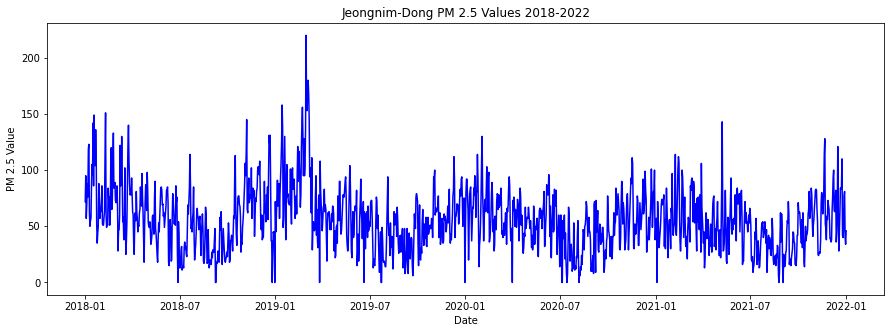

In [5]:
#displays a plot of the pm25 values since 2018
fig = plt.figure(figsize=(15,5))
plt.plot(pollution, color='blue')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Value')
plt.title('Jeongnim-Dong PM 2.5 Values 2018-2022')
plt.show()

In [6]:
#Split the time series data into a train and test set
end_train_ix = pd.to_datetime('2020-12-31')
train = pollution[:end_train_ix] # Jan 2018-2021
test = pollution[end_train_ix:] # Jan 2021-2022

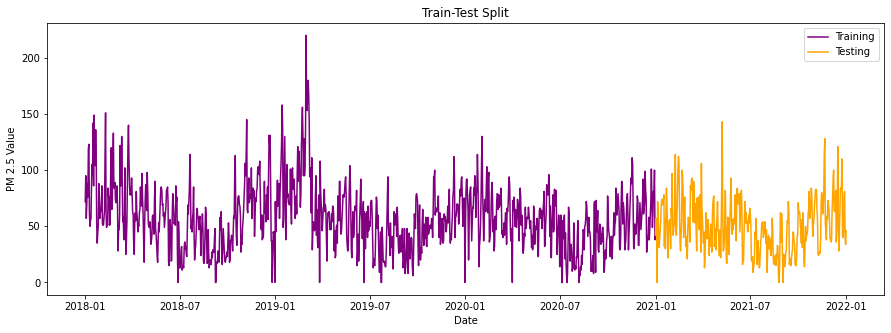

In [7]:
#displays a plot of the train/test split
fig = plt.figure(figsize=(15,5))
plt.plot(train, color='purple', label='Training')
plt.plot(test, color='orange', label='Testing')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Value')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [8]:
#Creates a windowed dataset from the time series data
WINDOW = 14 #the window value... 14 days

#converts values to TensorSliceDataset
train_data = tf.data.Dataset.from_tensor_slices(train.values) 

#takes window size + 1 slices of the dataset
train_data = train_data.window(WINDOW+1, shift=1, drop_remainder=True)

#flattens windowed data by batching 
train_data = train_data.flat_map(lambda x: x.batch(WINDOW+1))

#creates features and target tuple
train_data = train_data.map(lambda x: (x[:-1], x[-1]))

#shuffles dataset
train_data = train_data.shuffle(1_000)

#creates batches of windows
train_data = train_data.batch(32).prefetch(1)

In [9]:
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mae') < 10.0:
            print("MAE under 10.0... Stopping training")
            self.model.stop_training = True

my_callback = CustomCallback()

In [10]:
from tensorflow.keras.callbacks import LearningRateScheduler

#creates a function that updates the learning rate based on the epoch number
def scheduler(epoch, lr):
    if epoch < 2:
        return 0.01
    else:
        return lr * 0.99

lr_scheduler = LearningRateScheduler(scheduler)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Lambda, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber


lstm_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]), 
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

lstm_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 14, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 14, 256)          133120    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [12]:
#Trains LSTM Model
lstm_history = lstm_model.fit(
    train_data,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=0
)

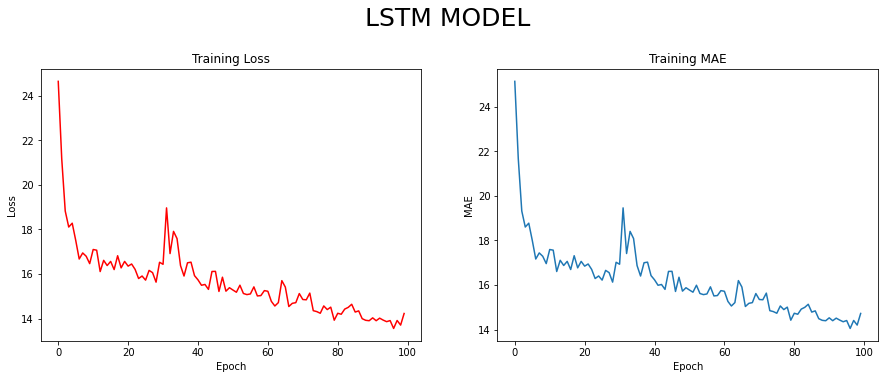

					FINAL LOSS: 14.23 | FINAL MAE: 14.73


In [13]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(lstm_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(lstm_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'LSTM MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(lstm_history.history['loss'][-1], 2),
                                                 round(lstm_history.history['mae'][-1] ,2)))

In [14]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Flatten


cnn_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]),
    Conv1D(filters=32, kernel_size=3, strides=1,
           padding='causal', activation='relu'),
    Conv1D(filters=64, kernel_size=3, strides=1, 
           padding='causal', activation='relu'),
    GlobalAveragePooling1D(),
    Flatten(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

cnn_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 14, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 14, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 64)            6208      
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                      

In [15]:
#Trains CNN Model
cnn_history = cnn_model.fit(
    train_data,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=0
)

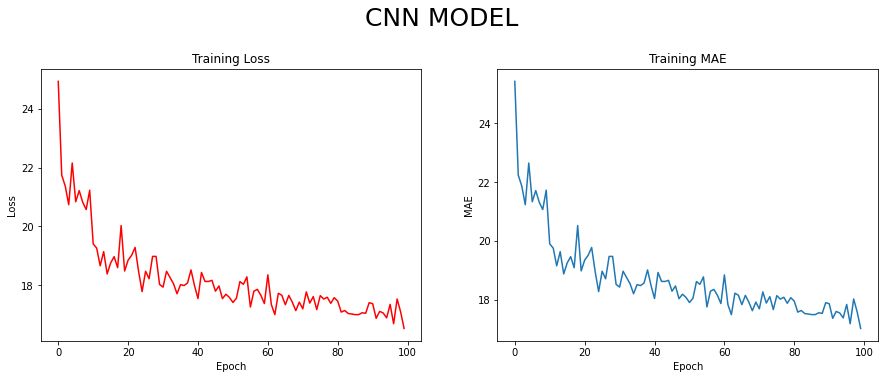

					FINAL LOSS: 16.54 | FINAL MAE: 17.03


In [16]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(cnn_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(cnn_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'CNN MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(cnn_history.history['loss'][-1], 2),
                                                 round(cnn_history.history['mae'][-1], 2)))

In [17]:
mixed_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]),
    Conv1D(filters=64, kernel_size=3, strides=1,
           padding='causal', activation='relu'),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(1)
])


mixed_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

mixed_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 14, 1)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 14, 64)            256       
                                                                 
 bidirectional_2 (Bidirectio  (None, 14, 256)          197632    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 512)              

In [18]:
#Trains Mixed Model
mixed_history = mixed_model.fit(
    train_data,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=0
)

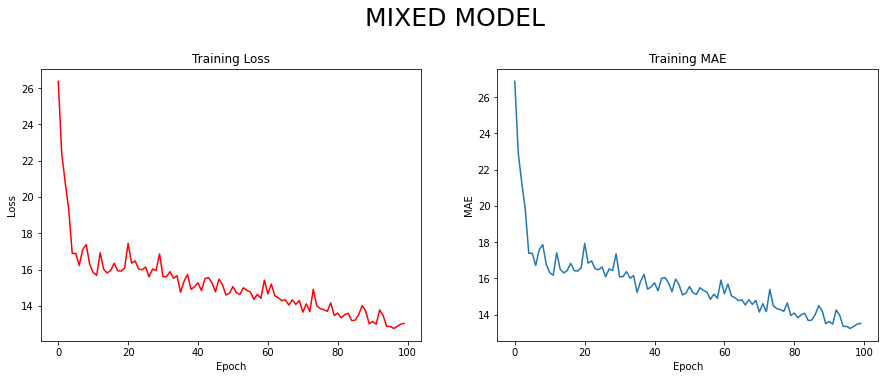

					FINAL LOSS: 13.03 | FINAL MAE: 13.52


In [19]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(mixed_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(mixed_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'MIXED MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(mixed_history.history['loss'][-1], 2),
                                                 round(mixed_history.history['mae'][-1], 2)))

In [20]:
#Gets forecasts of models

all_models = [('LSTM MODEL', lstm_model),
              ('CNN MODEL', cnn_model),
              ('MIXED MODEL', mixed_model)]

model_forecasts = {
    'LSTM MODEL': [],
    'CNN MODEL': [],
    'MIXED MODEL': []
}

#chunck of data to be windowed so that each window associated to a value in test set
forecast_data = train[-WINDOW:].append(test[:-1]).values

for name, model in all_models:
    #converts values to TensorSliceDataset
    test_data = tf.data.Dataset.from_tensor_slices(forecast_data) 
    #takes window size  slices of the dataset
    test_data = test_data.window(WINDOW, shift=1, drop_remainder=True)
    #flattens windowed data by batching 
    test_data = test_data.flat_map(lambda x: x.batch(WINDOW+1))
    #creates batches of windows
    test_data = test_data.batch(32).prefetch(1)
    #gets model prediction 
    preds = model.predict(test_data)
    #append to forecast dict
    model_forecasts[name].append(preds)

In [21]:
#Gets MAE score of model forecasts

N = test.values.shape[0] #number of samples in test set

lstm_mae = np.abs(test.values - model_forecasts['LSTM MODEL'][0].squeeze()).sum() / N

cnn_mae = np.abs(test.values - model_forecasts['CNN MODEL'][0].squeeze()).sum() / N

mix_mae = np.abs(test.values - model_forecasts['MIXED MODEL'][0].squeeze()).sum() / N


print('MODEL MAE SCORES')
print('=====================================')
print('LSTM MAE:', round(lstm_mae, 2))
print('CNN MAE:', round(cnn_mae, 2))
print('MIXED MAE:', round(mix_mae, 2))

MODEL MAE SCORES
LSTM MAE: 14.64
CNN MAE: 18.27
MIXED MAE: 14.84


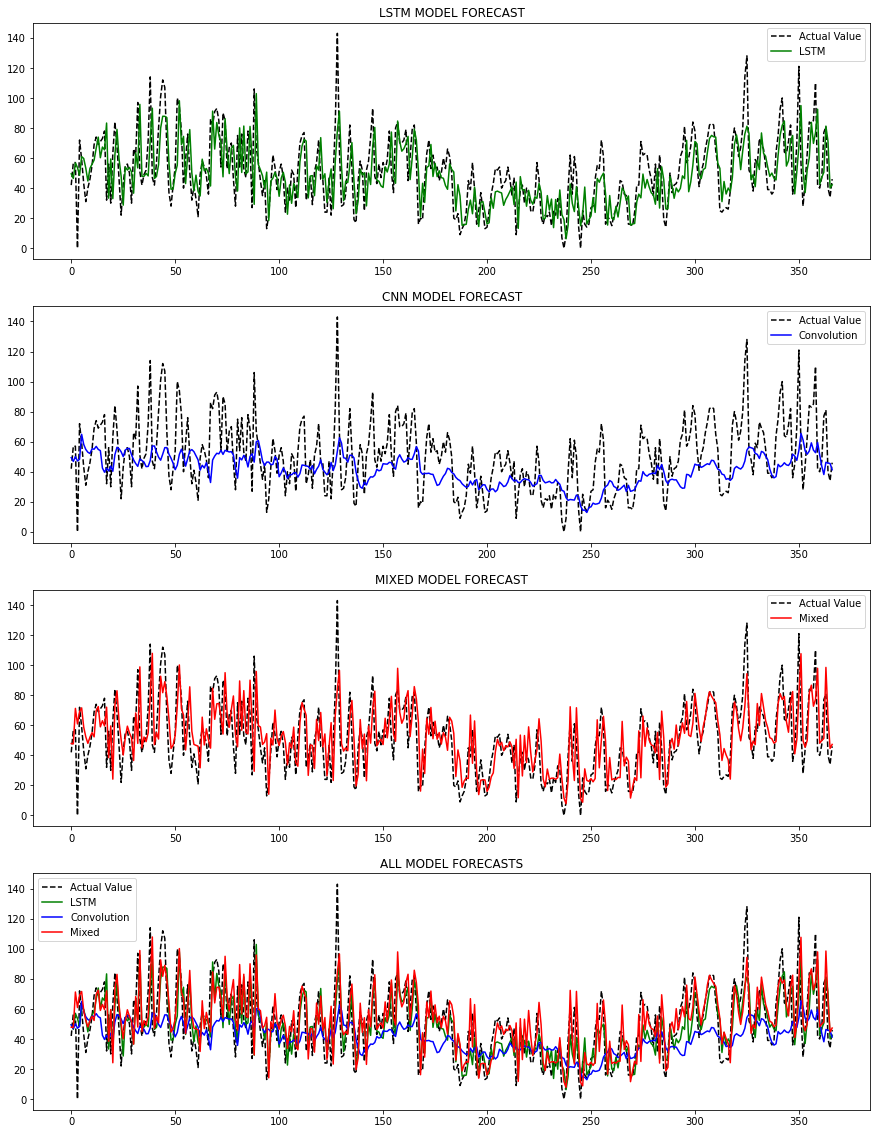

In [22]:
#displays forecasted data
plt.rcParams["figure.figsize"] = (15,20)
fig, axs = plt.subplots(4, 1)

#LSTM Forecast
axs[0].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[0].plot(model_forecasts['LSTM MODEL'][0].squeeze(), color='green', label='LSTM')
axs[0].set_title('LSTM MODEL FORECAST')
axs[0].legend()

#CNN Forcast
axs[1].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[1].plot(model_forecasts['CNN MODEL'][0].squeeze(), color='blue', label='Convolution')
axs[1].set_title('CNN MODEL FORECAST')
axs[1].legend()

#Mixed Model Forecast
axs[2].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[2].plot(model_forecasts['MIXED MODEL'][0].squeeze(), color='red', label='Mixed')
axs[2].set_title('MIXED MODEL FORECAST')
axs[2].legend()

#All forecasts
axs[3].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[3].plot(model_forecasts['LSTM MODEL'][0].squeeze(), color='green', label='LSTM')
axs[3].plot(model_forecasts['CNN MODEL'][0].squeeze(), color='blue', label='Convolution')
axs[3].plot(model_forecasts['MIXED MODEL'][0].squeeze(), color='red', label='Mixed')
axs[3].set_title('ALL MODEL FORECASTS')
axs[3].legend()


plt.show()
